In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import Table
#from merger_analysis import athena_read as ar
#from glob import glob
#from merger_analysis import OrbitAnalysisUtils as ou
from Constants import Constants

from mpl_toolkits.axes_grid1 import ImageGrid

import deepdish as dd


c=Constants()

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16


np.seterr(all='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
"""
Source code used in generating azimuthal averages, from 3D data. Included for clarity. 



def get_az_avg(d,var,mass_weight=True):
    nphi = d['rho'].shape[0]
    nth = d['rho'].shape[1]
    
    R = d['gx1v'][0,0:nth/2,:]*np.sin(d['gx2v'][0,0:nth/2,:])
    z = d['gx1v'][0,0:nth/2,:]*np.cos(d['gx2v'][0,0:nth/2,:])
    
    if mass_weight:
        dm = d['rho']*d['dvol']
        dmvar = d[var]*dm
        var = (np.sum(dmvar[:,0:nth/2,:] + dmvar[:,nth:nth/2-1:-1,:],axis=0)/
               np.sum(dm[:,0:nth/2,:]    + dm[:,nth:nth/2-1:-1,:],axis=0)) #(2*nphi) 
    else:
        var = np.sum(d[var][:,0:nth/2,:] + d[var][:,nth:nth/2-1:-1,:],axis=0)/(2*nphi)
    
    return R,z,var

def get_rho_avg_masked(d,p,gamma):
    
    # current time
    t = d['Time']
    # get properties of orbit
    rcom,vcom = ou.rcom_vcom(orb,t)
    
    d['entropy'] = np.log(d['press']/d['rho']**gamma)
    d['vR'] = np.sqrt((d['vx']-vcom[0])**2 + (d['vy']-vcom[1])**2)
    d['vZ'] = np.where(d['z']>0,d['vz'],-d['vz'])
    d['rcom'] = np.sqrt((d['x']-rcom[0])**2 + (d['y']-rcom[1])**2 + (d['z']-rcom[2])**2)
    #d['Rcom'] = np.sqrt((d['x']-rcom[0])**2 + (d['y']-rcom[1])**2 )
    d['vrcom'] = np.sqrt(  ((d['vx']-vcom[0])*(d['x']-rcom[0])/d['rcom'])**2 
                         + ((d['vy']-vcom[1])*(d['y']-rcom[1])/d['rcom'])**2 
                         + ((d['vz']-vcom[2])*(d['z']-rcom[2])/d['rcom'])**2 ) 
    d['l']     = (d['x']-rcom[0])*(d['vy']-vcom[0]) - (d['y']-rcom[1])*(d['vx']-vcom[1])
    
    R,z,entropy = get_az_avg(d,'entropy')
    R,z,rho     = get_az_avg(d,'rho',mass_weight=False)
    R,z,press   = get_az_avg(d,'press')
    R,z,vphi    = get_az_avg(d,'vel3')
    R,z,vz      = get_az_avg(d,'vZ')
    R,z,vR      = get_az_avg(d,'vR')
    R,z,vr      = get_az_avg(d,'vrcom')
    R,z,bern      = get_az_avg(d,'bern')
    R,z,ek      = get_az_avg(d,'ek')
    R,z,l      = get_az_avg(d,'l')
    
    davg = {}
    davg['R'] = R
    davg['z'] = z
    davg['rho'] = rho 
    davg['press'] = press
    davg['vphi']  = vphi
    davg['vz'] = vz
    davg['vR'] = vR
    davg['vr'] = vr
    davg['ek'] = ek
    davg['bern'] = bern
    davg['l'] = l
    davg['dA'] = (d['x2v'][1]-d['x2v'][0])*d['gx1v'][0,:,:]*np.gradient(d['gx1v'][0,:,:])
    
    entropy_cut = np.log(p['p']/p['rho']**gamma)[-1]*0.9
    density_cut = p['rho'][-1]*3.
    davg['mask'] =( (entropy>entropy_cut) | (rho<density_cut) ) 
    
    return davg
    
    
    
    
    
    
    
    
st = ascii.read('sim_table_bu.dat')


filelist = ["HSE.out0.00012.athdf","HSE.out0.00009.athdf","HSE.out0.00010.athdf","HSE.out0.00011.athdf",
           "HSE.out0.00005.athdf","HSE.out0.00010.athdf","HSE.out0.00013.athdf",
           "HSE.out0.00009.athdf","HSE.out0.00008.athdf","HSE.out0.00008.athdf",
           "HSE.out0.00010.athdf","HSE.out0.00010.athdf","HSE.out0.00009.athdf",
           "HSE.out0.00007.athdf"]

for i, mydir in enumerate(st['dir']):
    fn = mydir + filelist[i]
    trackfn = mydir + "pm_trackfile.dat"
    proffn = mydir + "hse_profile.dat"
    orb = ou.read_trackfile(trackfn)
    #t1 = ou.get_t1(orb)
    #print t1, ar.athdf(fn,quantities=[])['Time']
    d = ou.read_data(fn,orb,level=0,x1_min=1.0,get_energy=True,profile_file=proffn)
    p = ascii.read(proffn,names=['r','rho','p','m'])
    davg = get_rho_avg_masked(d,p,st['gamma_ad'][i])
    dd.io.save('angle_avg_files/'+ str(i) + '.h5',davg)
    print ("Saved: ", str(i) + '.h5')
    print ("-------------------------------")
    
    
"""

print("")

# Torus Analytic Profile Comparison & Fitting

In [5]:
from astropy.modeling import models,fitting
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
import seaborn as sns
import matplotlib.colors as colors


('i=', 0, ' GM=', 1.1, ' Mtorus = ', 0.024989696479789585, ' gad =', 1.6666666666666667, ' Ltorus =', 0.03137053024655871)
('l =', 1.2553385861220694)
('R0=', 63.8825645495109)
('(tied) K = ', 1.7409788797693586, ' gamma =', 1.3237573697586789)
('M_model/M_goal =', 1.0000000000000002)
('cl=', array([-10.,  -9.,  -8.,  -7.,  -6.]))
-25.529681509920426


(1.7409788797693586, 1.3237573697586789, 1.2553385861220694, 63.8825645495109)

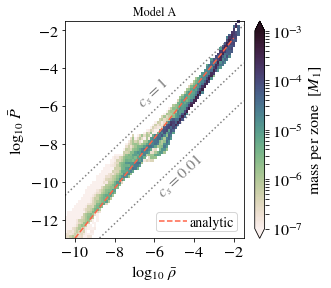

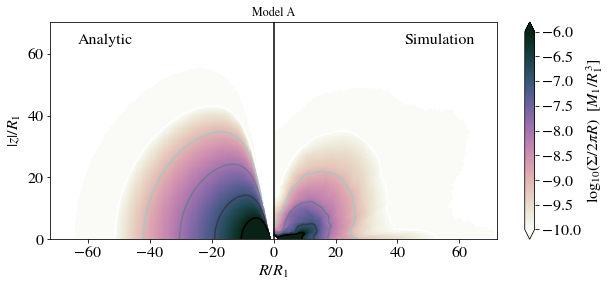

In [9]:
namelist = ['A','B','C','D','N','E','F','G','H','I','J','K','L','M']


from scipy.integrate import dblquad

def rho_torus(R,z,K=1.,gamma=5./3.,l=2.,GM=1.,R0=100.):
    r = np.sqrt(R**2 + z**2)
    return ((gamma-1.)/(K*gamma) * (GM/r - l**2/(2*R**2) - GM/R0 + l**2/(2*R0**2)))**(1./(gamma-1))

def Sigma_torus_K(R,z,K=1.,gamma=5./3.,l=2.,GM=1.,R0=100.):
    sigma = 2*np.pi*R*rho_torus(R,z,K=K,gamma=gamma,l=l,GM=GM,R0=R0) 
    return np.nan_to_num(sigma)

def M_torus_Kfast(davg,K=1,gamma=5./3.,l=2.,GM=1.,R0=100.):
    return 2*np.sum(davg['dA']*Sigma_torus_K(davg['R'],davg['z'],K,gamma,l,GM,R0) )

def K_M(davg,gamma,l,GM,R0,Mtorus):
    return 1*(M_torus_Kfast(davg,1.,gamma,l,GM,R0)/Mtorus)**((gamma-1))

def read_model(i):
    davg = dd.io.load('../AzAvgData/'+ str(i) + '.h5')

    #davg['sel'] = davg['bern']<= 0
    #davg['sel'] = (davg['rho']>1.e-10) 
    davg['sel'] = (davg['mask']==False)
    
    r = np.sqrt(davg['z']**2 + davg['R']**2)
    dr = np.gradient(r[0]) 
    dth = np.pi/192
    davg['dA'] = (r*dr*dth) 
    return davg    


def fit_torus_params(i,plot_figure=True):
    """takes model name i"""
    
    st = ascii.read('../sim_table_bu_torus.dat')
    
    st['L0'] = 1*st['m2']/np.sqrt(1+st['m2']) * np.sqrt(st["a0"])
    st['L1'] = (1-st['dm1'])*st['m2']/np.sqrt((1-st['dm1'])+st['m2']) * np.sqrt(1.0)
    st['dL1'] = st['L0'] - st['L1']
    
    GM = 1 + st['m2'][i]
    Mtorus = st['dm1'][i]
    Ltorus = st['dL1'][i]
    gad = st['gamma_ad'][i]
    print("i=",i," GM=",GM," Mtorus = ",Mtorus," gad =",gad, " Ltorus =",Ltorus)
    
    davg = read_model(i)
    
    # Selection
    davg['rhom'] = np.where(davg['sel'],davg['rho'],0)
    RR = davg['R']
    zz = davg['z']
    
    # fit l
    # Rvphi
    #l = np.sum(davg['R'][davg['sel']]*davg['vphi'][davg['sel']]*davg['dA'][davg['sel']])/np.sum(davg['dA'][davg['sel']])
    # area weighted
    #l = np.sum(davg['l'][davg['sel']]*davg['dA'][davg['sel']])/np.sum(davg['dA'][davg['sel']])
    # unweighted
    #l = np.sum(davg['l'][davg['sel']])/len(davg['l'][davg['sel']])
    # mass weighted  = Ltot/Mtot
    dm = 4*np.pi*davg['R'][davg['sel']]*davg['rho'][davg['sel']]*davg['dA'][davg['sel']]
    # L = np.sum(davg['l'][davg['sel']] * dm ) 
    #l = L/np.sum(dm)
    #print("M = ",np.sum(dm),"L =",L,"l = ",l)
    #print("dm1 = ",Mtorus," L=",st['dL1'][i]," l=",st['dL1'][i]/Mtorus)
    l = Ltorus/Mtorus
    print("l =",l)

    # fit R0
    nth = davg['R'].shape[0]
    thmin = int(nth/3)
    outer_indicies = np.argmin(davg['rhom'],axis=1)[thmin:nth]
    R0 = np.mean(np.sqrt(davg['R']**2 + davg['z']**2)[np.arange(thmin,nth),outer_indicies])
    print("R0=",R0)
    
    
    # fit K, gamma: P=K\rho^gamma
    x = np.log10(davg['rho'][davg['sel']].flatten() )
    y = np.log10(davg['press'][davg['sel']].flatten() )
    weights =  dm.flatten() #davg['dA'][davg['sel']]


    # tieing function to produce correct mass
    def log_K_model(t):
        return np.log10( K_M(davg,t.slope.value,l,GM,R0,Mtorus) )

    t_init = models.Linear1D()
    #t_init.slope.bounds = (1.01,1.7)
    t_init.intercept.tied = log_K_model
    fit_t = fitting.LevMarLSQFitter()
    t = fit_t(t_init, x, y,weights=weights)
    #print(fit_t.fit_info)
    K = 10**t.intercept.value
    gamma = t.slope.value
    print("(tied) K = ",K," gamma =",gamma)
    
    print ("M_model/M_goal =",M_torus_Kfast(davg,K=K,gamma=gamma,l=l,GM=GM,R0=R0)/Mtorus)

    
    if plot_figure:
        
         # MAKE PHASE SPACE FIGURE 
        plt.figure(figsize=(4,4))
        mycm = sns.cubehelix_palette(start=0.9, rot=-1,light=0.95,dark=.1,as_cmap=True)
        c,xe,ye,im=plt.hist2d(x,y,weights=weights,
                            bins=80,norm=colors.LogNorm(vmin=1.e-7,vmax=1.e-3),
                            range=[[-10.5,-1.5],[-13,-1.5]],
                            cmap=mycm,rasterized=True)

        #plt.grid(ls=':')
        plt.colorbar(im,label="mass per zone  [$M_1$]",extend='both')
        xp = np.linspace(-10,-2,10)
        plt.plot(xp,t(xp),ls='--',c='Tomato',label=r'analytic')
        
        xp = np.linspace(-10.5,-1.5,10)
        plt.annotate("$c_s=1$",(-7,-5),rotation=43 ,color="0.5")
        plt.annotate("$c_s=0.01$",(-6,-9),rotation=43 ,color="0.5")
        plt.plot(xp,np.log10(10**xp*1./gad),ls=':',color="0.5",zorder=0)
        plt.plot(xp,np.log10(10**xp*1.e-2/gad),ls=':',color="0.5",zorder=0)
        plt.plot(xp,np.log10(10**xp*1.e-4/gad),ls=':',color="0.5",zorder=0)

        plt.legend(loc='lower right',frameon=True)
        plt.xlabel(r'$\log_{10}\  \bar \rho$')
        plt.ylabel(r'$\log_{10}\ \bar P$')
        plt.xticks(np.arange(-10,0,2) )
        plt.title('Model '+namelist[i],fontsize=12)
        #plt.savefig("param_deltam_figures/az_avg_phase_space_"+str(i)+".pdf",bbox_inches='tight')
        ######
        
        
        
        
        ### COMPARISON FIGURE
        plt.figure(figsize=(10,4))
        
        lim=R0*1.1
        
        vmin=-10
        vmax=-6
        cl = np.linspace(vmin,vmax,int((vmax-vmin) +1))
        print("cl=",cl)
        cmap =sns.cubehelix_palette(start=1.9, rot=0.9,light=0.98,dark=.1,as_cmap=True) #'PuRd'
        cmap_contour = 'bone_r'

        R = np.linspace(1,1.1*R0,200)
        z = np.linspace(0,1.1*R0,200)

        RR,zz = np.meshgrid(R,z)
        log_rho = np.log10(rho_torus(RR,zz,K=K,l=l,R0=R0,gamma=gamma,GM=GM))
        print( np.min(np.nan_to_num(log_rho)) )
        im=plt.pcolormesh(-RR,zz,log_rho,cmap=cmap,vmax=vmax,vmin=vmin,rasterized=True)
        plt.contour(-RR,zz,log_rho,cmap=cmap_contour,linestyles='solid',levels=cl )
        #plt.colorbar(im)
        
        plt.pcolormesh(davg['R'],davg['z'],np.log10(davg['rhom']),cmap=cmap,vmax=vmax,vmin=vmin,rasterized=True )
        plt.contour(davg['R'],davg['z'],np.log10(davg['rhom'] ),cmap=cmap_contour,linestyles='solid',levels=cl )
        plt.colorbar(im,label=r'$\log_{10}\left(\Sigma/2\pi R \right) \ \ [M_1/R_1^3]$',extend='both')

        plt.xlabel('$R/R_1$')
        plt.ylabel('$|z|/R_1$')
        #plt.show()
        #plt.xticks(np.arange(-100,120,20),np.abs(np.arange(-100,120,20)) ) 
        plt.axis('equal')
        plt.xlim(-lim,lim)
        plt.ylim(0,lim)

        plt.axvline(0,color='k',ls='-')
        plt.annotate('Simulation',(lim*0.6,lim*0.9))
        plt.annotate('Analytic',(-lim*0.9,lim*0.9))
        plt.title('Model '+namelist[i],fontsize=12)
        #plt.savefig("param_deltam_figures/az_avg_torus_"+str(i)+".pdf",bbox_inches='tight')

        
   
    return  K,gamma,l,R0


fit_torus_params(0)

('i=', 0, ' GM=', 1.1, ' Mtorus = ', 0.024989696479789585, ' gad =', 1.6666666666666667, ' Ltorus =', 0.03137053024655871)
('l =', 1.2553385861220694)
('R0=', 63.8825645495109)
('(tied) K = ', 1.7409788797693586, ' gamma =', 1.3237573697586789)
('M_model/M_goal =', 1.0000000000000002)
('cl=', array([-10.,  -9.,  -8.,  -7.,  -6.]))
-25.529681509920426
('i=', 1, ' GM=', 1.1, ' Mtorus = ', 0.023031875742085702, ' gad =', 1.6666666666666667, ' Ltorus =', 0.03126738850729055)
('l =', 1.3575702151846996)
('R0=', 59.97028200004081)
('(tied) K = ', 1.6549659686011797, ' gamma =', 1.3227242842869422)
('M_model/M_goal =', 0.9999999999999996)
('cl=', array([-10.,  -9.,  -8.,  -7.,  -6.]))
-22.753534457705214
('i=', 2, ' GM=', 1.1, ' Mtorus = ', 0.02172208584844887, ' gad =', 1.6666666666666667, ' Ltorus =', 0.031198447493919756)
('l =', 1.436254681598525)
('R0=', 58.43288517447904)
('(tied) K = ', 2.4018549215383875, ' gamma =', 1.3476577977690716)
('M_model/M_goal =', 1.0000000000000002)
('cl=',

/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


('i=', 11, ' GM=', 1.3, ' Mtorus = ', 0.04496745408979152, ' gad =', 1.5, ' Ltorus =', 0.09232379537670304)
('l =', 2.0531248042717705)
('R0=', 96.70013600488936)
('(tied) K = ', 2.190057895761477, ' gamma =', 1.3467647043916326)
('M_model/M_goal =', 1.0000000000000004)
('cl=', array([-10.,  -9.,  -8.,  -7.,  -6.]))
-21.069384730688146
('i=', 12, ' GM=', 1.3, ' Mtorus = ', 0.04642026720336932, ' gad =', 1.6666666666666667, ' Ltorus =', 0.09256491484820273)
('l =', 1.994062516759578)
('R0=', 96.185957886568)
('(tied) K = ', 1.808444056051916, ' gamma =', 1.3349835483602492)
('M_model/M_goal =', 1.0000000000000009)
('cl=', array([-10.,  -9.,  -8.,  -7.,  -6.]))
-22.296222178586756
('i=', 13, ' GM=', 1.1, ' Mtorus = ', 0.021795332073651495, ' gad =', 1.6666666666666667, ' Ltorus =', 0.0244990129239573)
('l =', 1.1240486192717523)
('R0=', 9.80481662806481)
('(tied) K = ', 0.7924911735287392, ' gamma =', 1.3082370805719654)
('M_model/M_goal =', 0.9999999999999993)
('cl=', array([-10.,  -9.,

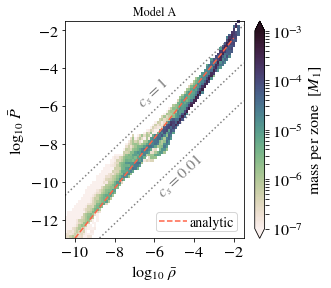

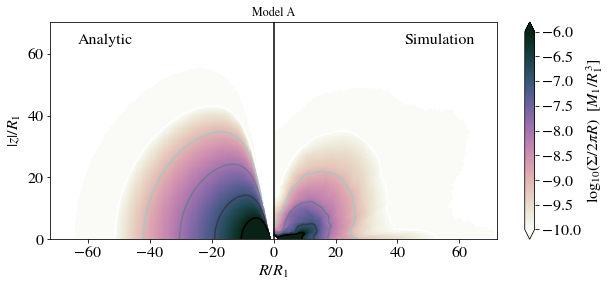

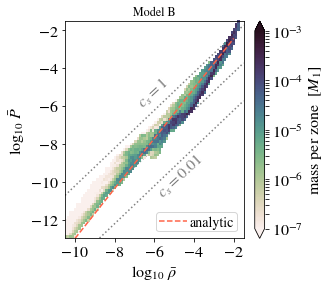

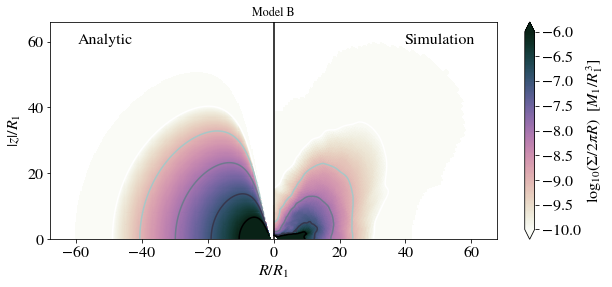

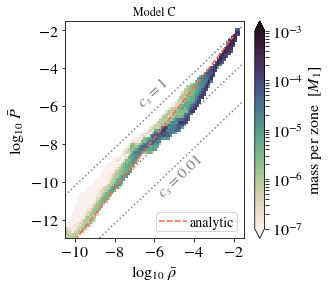

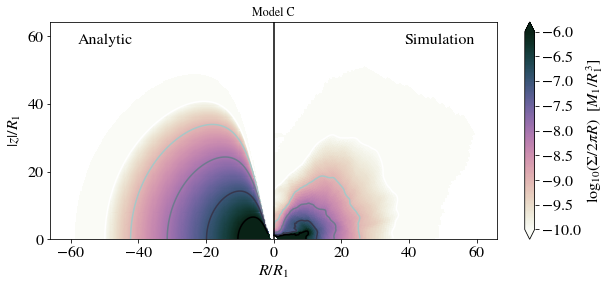

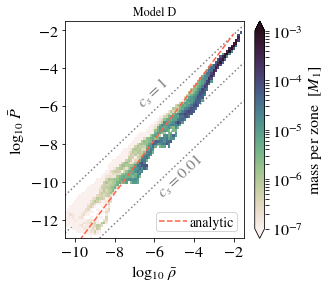

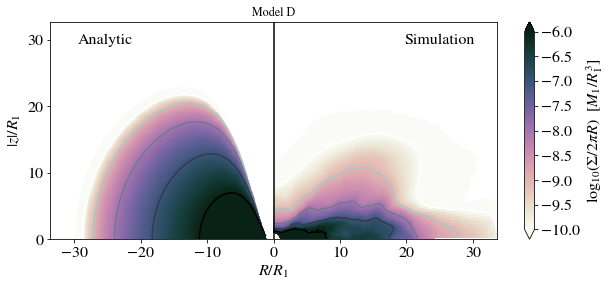

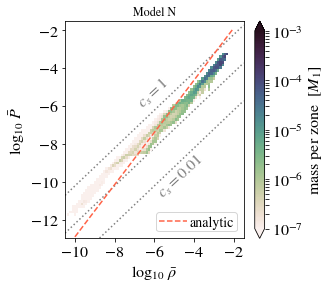

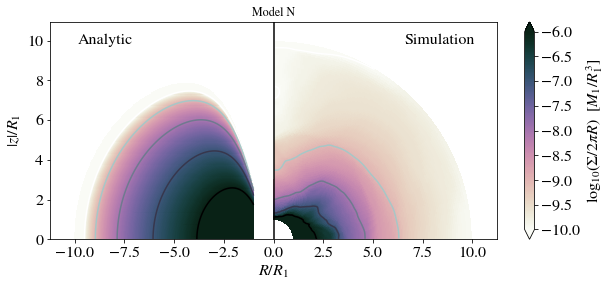

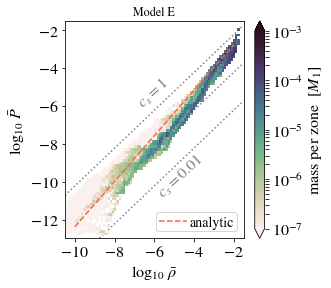

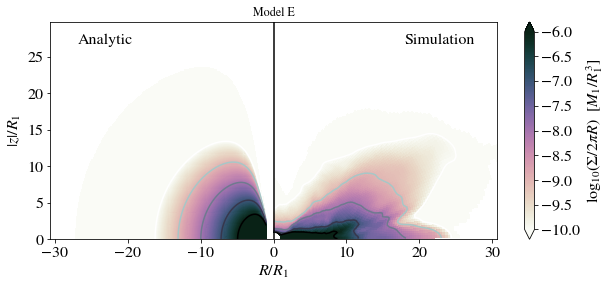

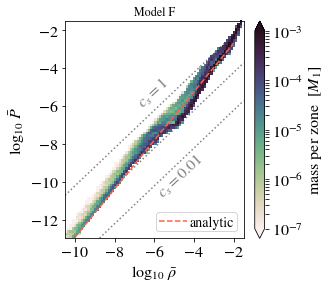

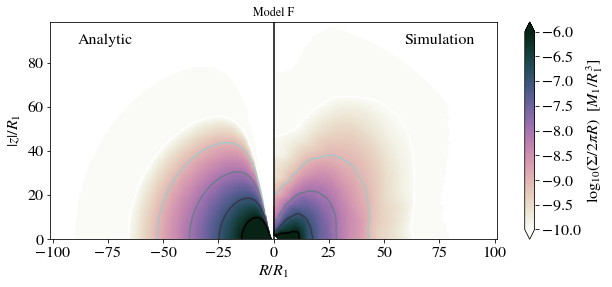

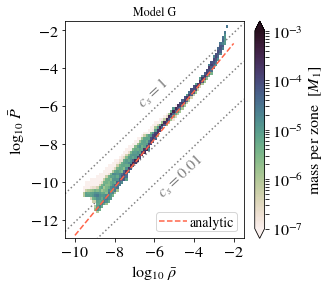

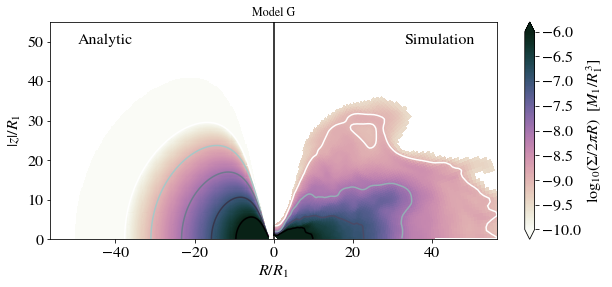

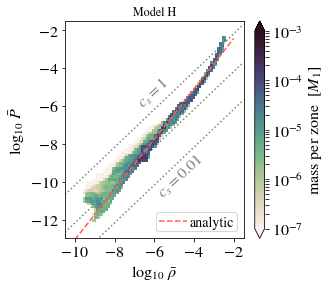

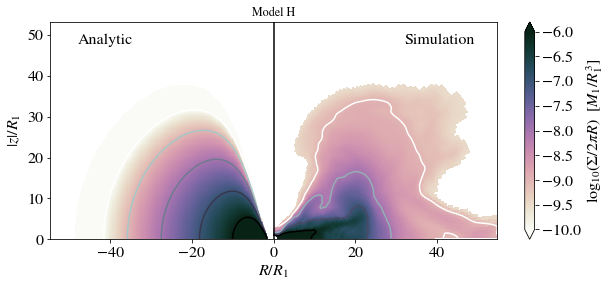

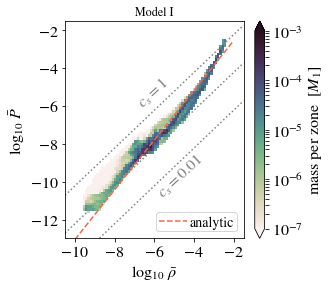

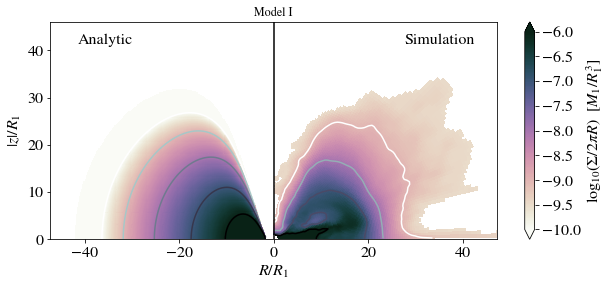

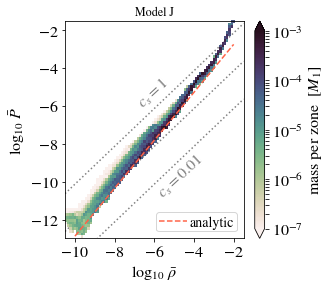

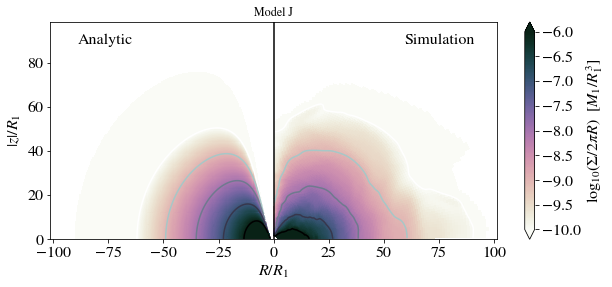

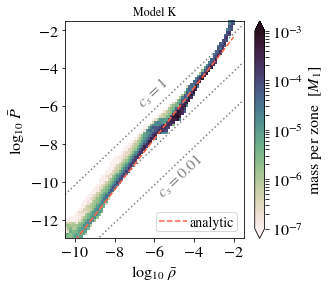

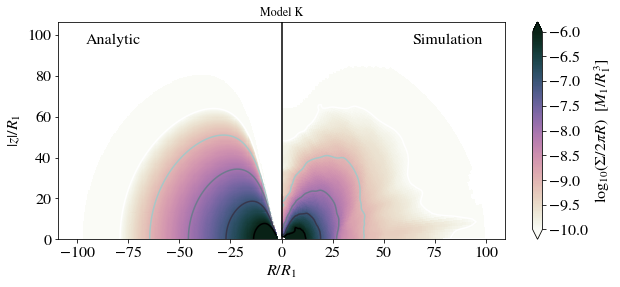

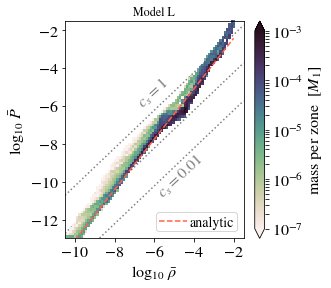

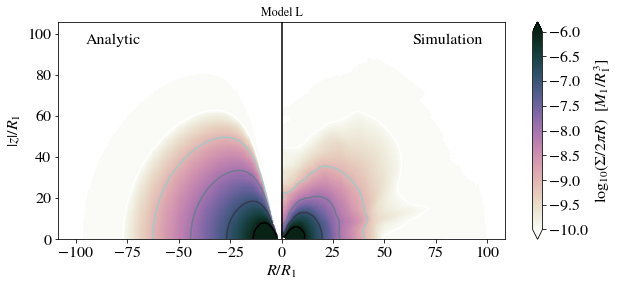

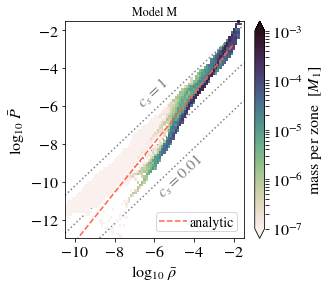

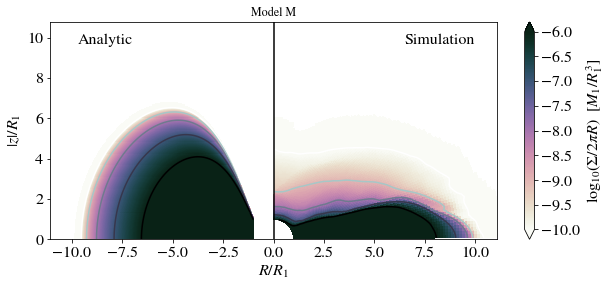

In [10]:
st = ascii.read('../sim_table_bu_torus.dat')

st['K_torus'] = 0.0
st['gamma_torus'] = 0.0
st['l_torus'] = 0.0
st['R0_torus'] = 0.0

for i in range(14):
    K,gamma,l,R0 = fit_torus_params(i,plot_figure=True)  
    st['K_torus'][i] = K
    st['gamma_torus'][i] = gamma
    st['l_torus'][i] = l
    st['R0_torus'][i] = R0
    

In [274]:
#ascii.write(st,output="sim_table_bu_torus.dat")

# Torus Parameters Analysis

In [178]:
st = ascii.read("../sim_table_bu_torus.dat")

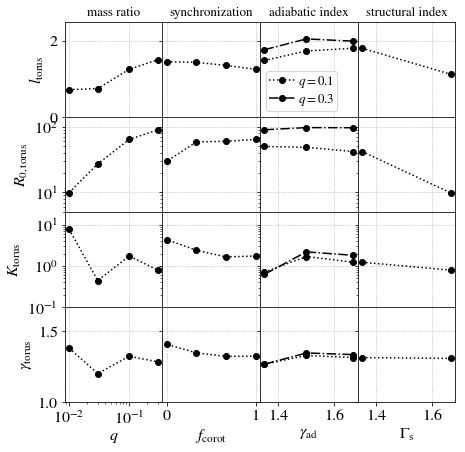

In [12]:
plt.figure(figsize=(7,7))
fst=13
######################## l_torus ##############################################
var='l_torus'
ymin=0.
ymax=2.5
yscale='linear'
ylabel=r"$l_{\rm torus}$"
# Mass Ratio
plt.subplot(441)
plt.title('mass ratio',fontsize=fst)
#sel = ( st['fcorot']==1) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
sel = ((st['fcorot']==1) | (st['m2']==0.01)) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
plt.plot(st[sel][[1,2,0,3]]['m2'],st[sel][[1,2,0,3]][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
#plt.xlim(0.01,1/3.)
plt.grid(ls=":")
plt.xscale('log')
plt.yscale(yscale)
#plt.xlabel(r'$q$')
plt.ylabel(ylabel)
plt.xticks(visible=False)

# Synchronization
plt.subplot(442)
plt.title('synchronization',fontsize=fst)
sel = ((st['m2']==0.1) & (st['gamma_structure']==5./3.)  & (st['a0']!=1.55))
plt.plot(st[sel]['fcorot'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r'$f_{\rm corot}$')
plt.yscale(yscale)
plt.xticks(visible=False)

# Adiabatic Index
plt.subplot(443)
plt.title('adiabatic index',fontsize=fst)
sel = ( (st['m2']==0.1) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko:',label=r'$q=0.1$')
sel = ( (st['m2']==0.3) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko-.',label=r'$q=0.3$')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r"$\gamma_{\rm ad}$")
plt.yscale(yscale)
plt.xticks(visible=False)
plt.legend(loc=0,frameon=True,fontsize=fst)

# Structural Index
plt.subplot(444)
plt.title('structural index',fontsize=fst)
sel = ((st['m2']==0.1) & (st['gamma_ad']==5./3.) & (st['fcorot']==1.0) & (st['a0']==1.55))
plt.plot(st[sel]['gamma_structure'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r"$\Gamma_{\rm s}$")
plt.yscale(yscale)
plt.xticks(visible=False)


######################## R0_torus ##############################################
var='R0_torus'
ymin=5
ymax=140.
yscale='log'
ylabel=r"$R_{0,\rm torus}$"
# Mass Ratio
plt.subplot(445)
#plt.title('mass ratio')
#sel = ( st['fcorot']==1) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
sel = ((st['fcorot']==1) | (st['m2']==0.01)) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
plt.plot(st[sel][[1,2,0,3]]['m2'],st[sel][[1,2,0,3]][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
#plt.xlim(0.01,1/3.)
plt.grid(ls=":")
plt.xscale('log')
plt.yscale(yscale)
#plt.xlabel(r'$q$')
plt.ylabel(ylabel)
plt.xticks(visible=False)

# Synchronization
plt.subplot(446)
#plt.title('synchronization')
sel = ((st['m2']==0.1) & (st['gamma_structure']==5./3.)  & (st['a0']!=1.55))
plt.plot(st[sel]['fcorot'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r'$f_{\rm corot}$')
plt.yscale(yscale)
plt.xticks(visible=False)

# Adiabatic Index
plt.subplot(447)
#plt.title('adiabatic index')
sel = ( (st['m2']==0.1) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko:',label='simulations')
sel = ( (st['m2']==0.3) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko-.',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r"$\gamma_{\rm ad}$")
plt.yscale(yscale)
plt.xticks(visible=False)

# Structural Index
plt.subplot(448)
#plt.title('structural index')
sel = ((st['m2']==0.1) & (st['gamma_ad']==5./3.) & (st['fcorot']==1.0) & (st['a0']==1.55))
plt.plot(st[sel]['gamma_structure'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r"$\Gamma_{\rm s}$")
plt.yscale(yscale)
plt.xticks(visible=False)


######################## K_torus ##############################################
var='K_torus'
ymin=0.1
ymax=20.
yscale='log'
ylabel=r"$K_{\rm torus}$"
# Mass Ratio
plt.subplot(4,4,9)
#plt.title('mass ratio')
#sel = ( st['fcorot']==1) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
sel = ((st['fcorot']==1) | (st['m2']==0.01)) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
plt.plot(st[sel][[1,2,0,3]]['m2'],st[sel][[1,2,0,3]][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
#plt.xlim(0.01,1/3.)
plt.grid(ls=":")
plt.xscale('log')
plt.yscale(yscale)
#plt.xlabel(r'$q$')
plt.ylabel(ylabel)
plt.xticks(visible=False)

# Synchronization
plt.subplot(4,4,10)
#plt.title('synchronization')
sel = ((st['m2']==0.1) & (st['gamma_structure']==5./3.)  & (st['a0']!=1.55))
plt.plot(st[sel]['fcorot'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r'$f_{\rm corot}$')
plt.yscale(yscale)
plt.xticks(visible=False)

# Adiabatic Index
plt.subplot(4,4,11)
#plt.title('adiabatic index')
sel = ( (st['m2']==0.1) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko:',label='simulations')
sel = ( (st['m2']==0.3) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko-.',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r"$\gamma_{\rm ad}$")
plt.yscale(yscale)
plt.xticks(visible=False)

# Structural Index
plt.subplot(4,4,12)
#plt.title('structural index')
sel = ((st['m2']==0.1) & (st['gamma_ad']==5./3.) & (st['fcorot']==1.0) & (st['a0']==1.55))
plt.plot(st[sel]['gamma_structure'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
#plt.xlabel(r"$\Gamma_{\rm s}$")
plt.yscale(yscale)
plt.xticks(visible=False)

######################## gamma_torus ##############################################
var='gamma_torus'
ymin=1.
ymax=5/3.
yscale='linear'
ylabel=r"$\gamma_{\rm torus}$"
# Mass Ratio
plt.subplot(4,4,13)
#plt.title('mass ratio')
#sel = ( st['fcorot']==1) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
sel = ((st['fcorot']==1) | (st['m2']==0.01)) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
plt.plot(st[sel][[1,2,0,3]]['m2'],st[sel][[1,2,0,3]][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
#plt.xlim(0.01,1/3.)
plt.grid(ls=":")
plt.xscale('log')
plt.yscale(yscale)
plt.xlabel(r'$q$')
plt.ylabel(ylabel)
#plt.xticks(visible=False)

# Synchronization
plt.subplot(4,4,14)
#plt.title('synchronization')
sel = ((st['m2']==0.1) & (st['gamma_structure']==5./3.)  & (st['a0']!=1.55))
plt.plot(st[sel]['fcorot'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r'$f_{\rm corot}$')
plt.yscale(yscale)
#plt.xticks(visible=False)

# Adiabatic Index
plt.subplot(4,4,15)
#plt.title('adiabatic index')
sel = ( (st['m2']==0.1) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko:',label='simulations')
sel = ( (st['m2']==0.3) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel][var],'ko-.',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\gamma_{\rm ad}$")
plt.yscale(yscale)
#plt.xticks(visible=False)

# Structural Index
plt.subplot(4,4,16)
#plt.title('structural index')
sel = ((st['m2']==0.1) & (st['gamma_ad']==5./3.) & (st['fcorot']==1.0) & (st['a0']==1.55))
plt.plot(st[sel]['gamma_structure'],st[sel][var],'ko:',label='simulations')
plt.ylim(ymin,ymax)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\Gamma_{\rm s}$")
plt.yscale(yscale)
#plt.xticks(visible=False)




plt.subplots_adjust(wspace=0,hspace=0)
#plt.savefig("param_deltam_figures/torus_parameters.pdf",bbox_inches='tight')

# Properties Figure 

In [15]:
from mpl_toolkits.axes_grid1 import ImageGrid


mycm1 = sns.cubehelix_palette(start=0.6,rot=-0.6,light=0.98,dark=.2,as_cmap=True)
mycm2 = sns.cubehelix_palette(start=1.9,rot=0.6,light=0.98,dark=.2,as_cmap=True)


def plot_torus_IG(i):
    """takes model name i"""
    
    st = ascii.read('../sim_table_bu_torus.dat')
    GM = 1 + st['m2'][i]
    Mtorus = st['dm1'][i]
    gad = st['gamma_ad'][i]
    print("i=",i," GM=",GM," Mtorus = ",Mtorus," gad =",gad)
    
    davg = read_model(i)
    
     

    fig = plt.figure(figsize=(4., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(4, 1),  # creates 2x2 grid of axes
                     axes_pad=0.,  # pad between axes in inch.
                     cbar_mode='each',
                     cbar_location='right'
                     )

    grid[0].axes.set_title('Model '+namelist[i],fontsize=12)
    
    
    lim=st['R0_torus'][i]*1.1
    ylim = lim*0.71
    
    # first panel rho
    ind = 0
    
    davg['rhom'] = np.where(davg['sel'],davg['rho'],np.nan)
    cmap =sns.cubehelix_palette(start=1.9, rot=0.9,light=0.98,dark=.1,as_cmap=True) #'PuRd'
    im=grid[ind].pcolormesh(davg['R'],davg['z'],np.log10(davg['rhom']),cmap=cmap,rasterized=True,vmax=-5 )
    cb=grid[ind].axes.cax.colorbar(im)
    cb.set_label_text(r'$\log_{10}\left(\Sigma / 2\pi R \right) \ \ [M_1/R_1^3]$')
    cb.solids.set_edgecolor("face")
    
    grid[ind].set_xlabel('$R/R_1$')
    grid[ind].set_ylabel('$|z|/R_1$')
    grid[ind].set_xlim(0,lim)
    grid[ind].set_ylim(0,ylim)
    
    
    # second vr
    ind = 1
    davg['vrm'] = np.where(davg['sel'],davg['vr'],np.nan)
    cmap =mycm1
    im=grid[ind].pcolormesh(davg['R'],davg['z'],davg['vrm'],cmap=cmap,rasterized=True,vmin=0,vmax=0.7 )
    cb=grid[ind].axes.cax.colorbar(im)
    cb.set_label_text(r'$\bar v_r \ \ \left[(GM_1/R_1)^{1/2}\right]$')
    cb.solids.set_edgecolor("face")
    
    grid[ind].set_xlabel('$R/R_1$')
    grid[ind].set_ylabel('$|z|/R_1$')
    grid[ind].set_xlim(0,lim)
    grid[ind].set_ylim(0,ylim)
    
    
    # third l
    ind = 2
    davg['lm'] = np.where(davg['sel'],davg['l'],np.nan)
    # unweighted 
    #davg['lm'] = np.where(davg['sel'],davg['l'],np.nan)
    cmap =mycm2 #'PuRd'
    im=grid[ind].pcolormesh(davg['R'],davg['z'],davg['lm'],cmap=cmap,rasterized=True,vmin=0,vmax=4.5 )
    cb=grid[ind].axes.cax.colorbar(im)
    cb.set_label_text(r'$\bar l  \ \ \left[(G M_1 R_1)^{1/2}\right]$')
    cb.solids.set_edgecolor("face")
    
    grid[ind].set_xlabel('$R/R_1$')
    grid[ind].set_ylabel('$|z|/R_1$')
    grid[ind].set_xlim(0,lim)
    grid[ind].set_ylim(0,ylim)
    
    
    # fourth Bern
    ind = 3
    davg['bernm'] = np.where(davg['sel'],davg['bern'],np.nan)
    #cmap =sns.cubehelix_palette(start=1.9, rot=0.9,light=0.98,dark=.1,as_cmap=True) #'PuRd'
    im=grid[ind].pcolormesh(davg['R'],davg['z'],davg['bernm'],cmap='PuOr_r',vmin=-0.1,vmax=0.1,rasterized=True )
    cb=grid[ind].axes.cax.colorbar(im)
    cb.set_label_text(r'${\cal \bar B} \ \ \left[ G M_1 / R_1 \right]$')
    cb.solids.set_edgecolor("face")
    
    grid[ind].set_xlabel('$R/R_1$')
    grid[ind].set_ylabel('$|z|/R_1$')
    grid[ind].set_xlim(0,lim)
    grid[ind].set_ylim(0,ylim)
   
    
    #plt.savefig("param_deltam_figures/az_avg_dens_kinematics_"+str(i)+".pdf",bbox_inches='tight')


('i=', 0, ' GM=', 1.1, ' Mtorus = ', 0.024989696479789585, ' gad =', 1.6666666666666667)


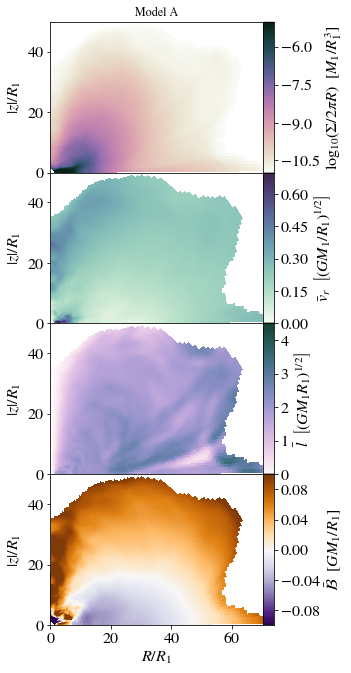

In [16]:
plot_torus_IG(0)

('i=', 0, ' GM=', 1.1, ' Mtorus = ', 0.024989696479789585, ' gad =', 1.6666666666666667)
('i=', 1, ' GM=', 1.1, ' Mtorus = ', 0.023031875742085702, ' gad =', 1.6666666666666667)
('i=', 2, ' GM=', 1.1, ' Mtorus = ', 0.02172208584844887, ' gad =', 1.6666666666666667)
('i=', 3, ' GM=', 1.1, ' Mtorus = ', 0.02140850396531647, ' gad =', 1.6666666666666667)
('i=', 4, ' GM=', 1.01, ' Mtorus = ', 0.0013317252489667467, ' gad =', 1.6666666666666667)
('i=', 5, ' GM=', 1.03, ' Mtorus = ', 0.009231671322144645, ' gad =', 1.6666666666666667)
('i=', 6, ' GM=', 1.3, ' Mtorus = ', 0.08556287597064394, ' gad =', 1.6666666666666667)
('i=', 7, ' GM=', 1.1, ' Mtorus = ', 0.016290063082095567, ' gad =', 1.35)
('i=', 8, ' GM=', 1.1, ' Mtorus = ', 0.013870542542690973, ' gad =', 1.5)
('i=', 9, ' GM=', 1.1, ' Mtorus = ', 0.01330754924408533, ' gad =', 1.6666666666666667)
('i=', 10, ' GM=', 1.3, ' Mtorus = ', 0.052915788032318604, ' gad =', 1.35)
('i=', 11, ' GM=', 1.3, ' Mtorus = ', 0.04496745408979152, ' gad

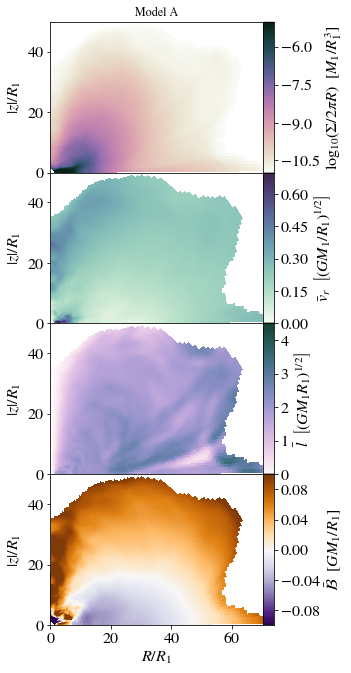

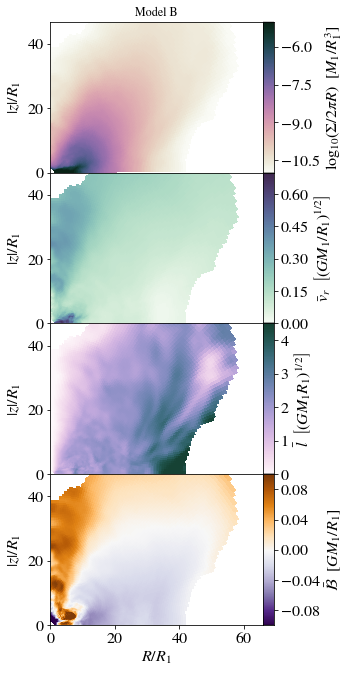

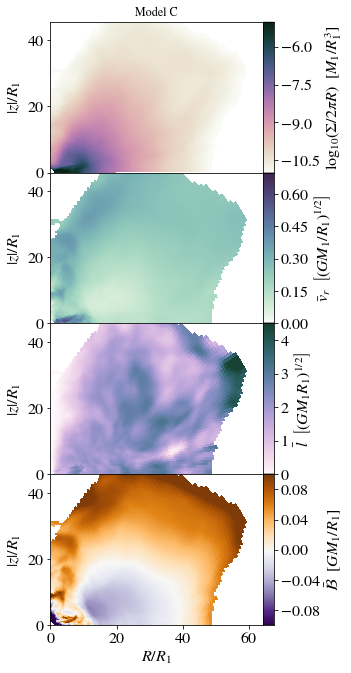

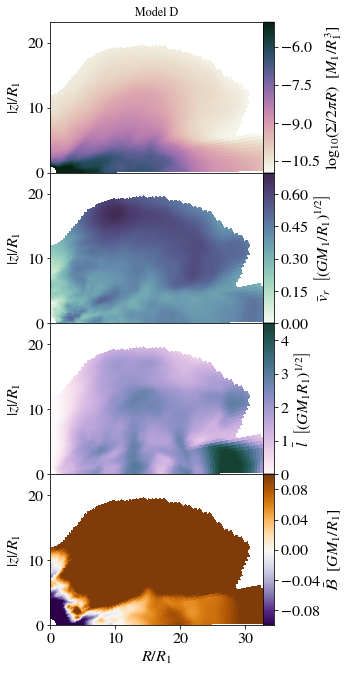

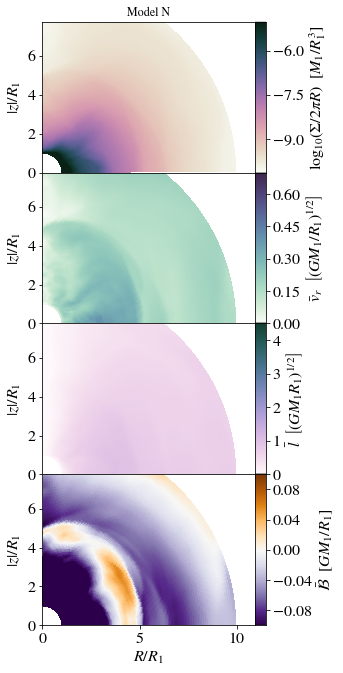

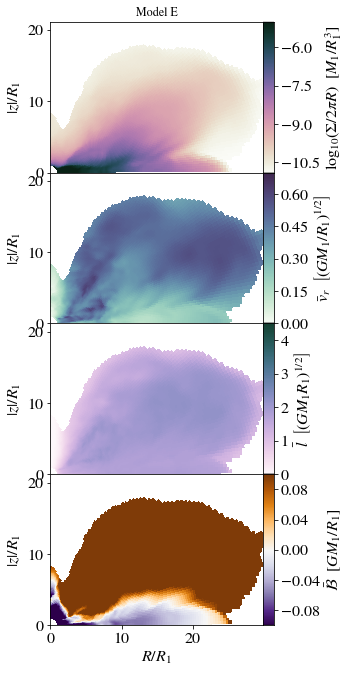

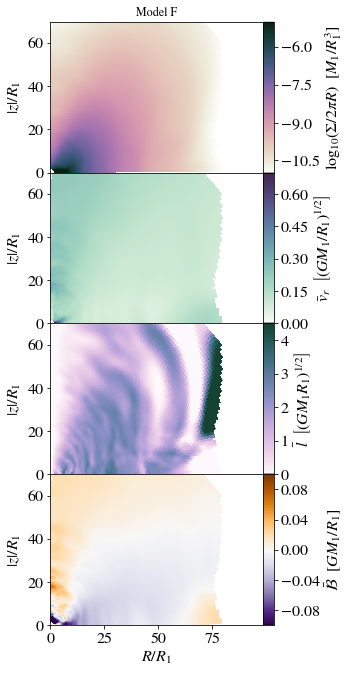

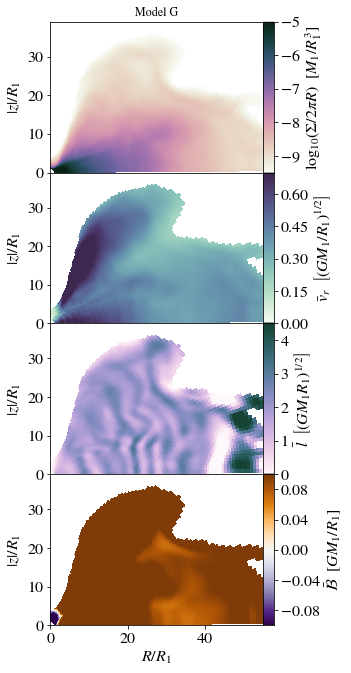

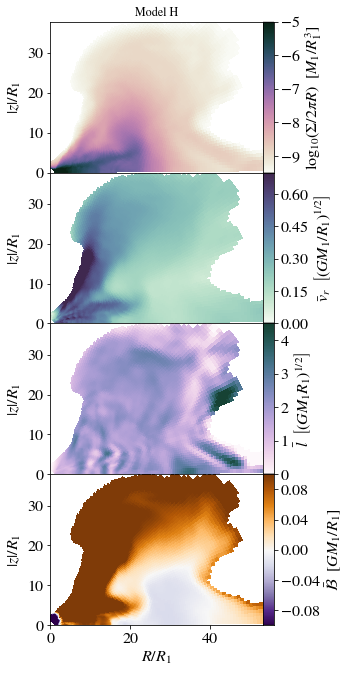

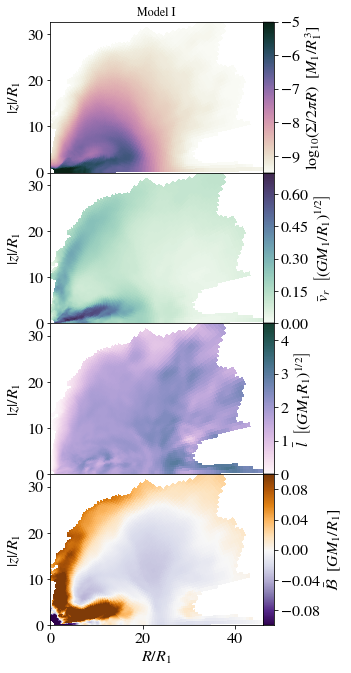

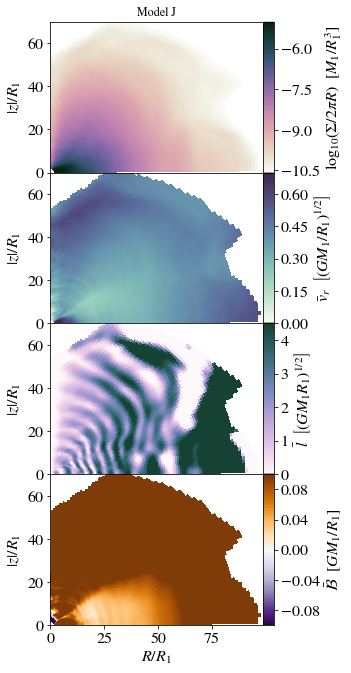

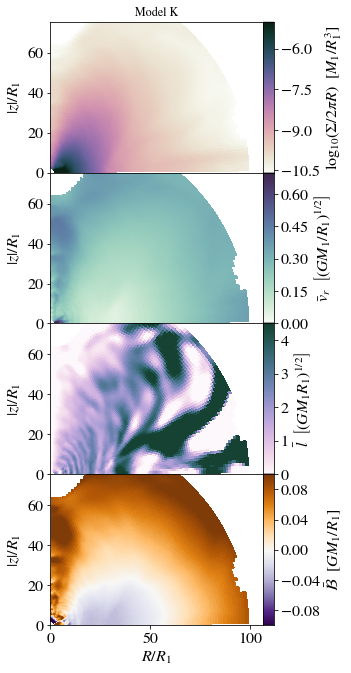

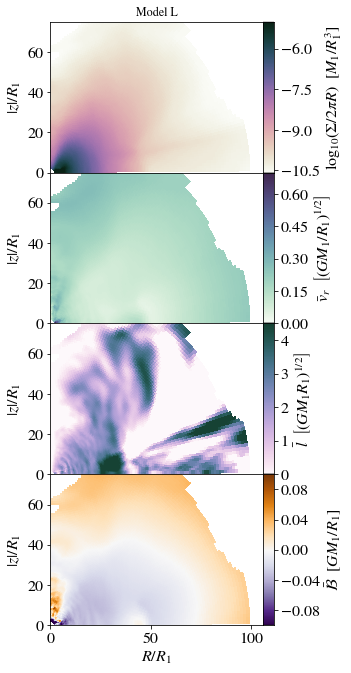

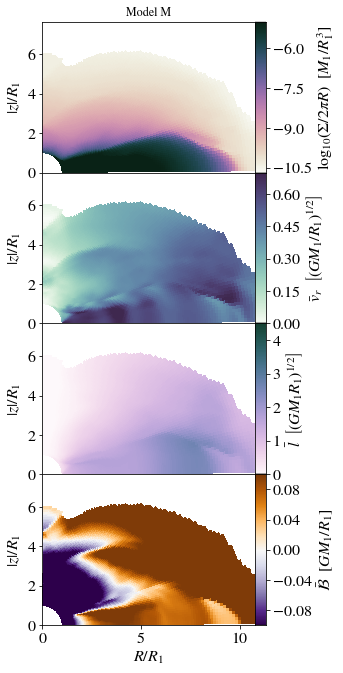

In [286]:
for i in range(14):
    plot_torus_IG(i)

In [241]:
ascii.write( st[['l_torus','R0_torus','K_torus','gamma_torus']] , format='latex',
            names=[r'$l_{\rm torus}$',r'$R_{0,\rm torus}$',r'$K_{\rm torus}$',r'$\gamma_{\rm torus}$'],
            formats={r'$l_{\rm torus}$': '%4.2f',r'$R_{0,\rm torus}$': '%4.2f',r'$K_{\rm torus}$': '%4.2f',r'$\gamma_{\rm torus}$': '%4.2f'}
           )

\begin{table}
\begin{tabular}{cccc}
$l_{\rm torus}$ & $R_{0,\rm torus}$ & $K_{\rm torus}$ & $\gamma_{\rm torus}$ \\
1.26 & 63.88 & 1.74 & 1.32 \\
1.36 & 59.97 & 1.65 & 1.32 \\
1.44 & 58.43 & 2.40 & 1.35 \\
1.46 & 29.74 & 4.33 & 1.41 \\
0.72 & 9.95 & 7.67 & 1.38 \\
0.75 & 27.10 & 0.44 & 1.20 \\
1.50 & 89.45 & 0.79 & 1.28 \\
1.49 & 50.00 & 0.71 & 1.27 \\
1.74 & 48.39 & 1.69 & 1.33 \\
1.81 & 41.86 & 1.23 & 1.31 \\
1.77 & 89.65 & 0.63 & 1.27 \\
2.05 & 96.70 & 2.19 & 1.35 \\
1.99 & 96.19 & 1.81 & 1.33 \\
1.12 & 9.80 & 0.79 & 1.31 \\
\end{tabular}
\end{table}
